## My dearest Wesleykins,

Alright, it's all ready to go. It's just the last cell at the bottom.



In [1]:
#import cv2
import numpy as np
import matplotlib
import scipy.io
import scipy.optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import pandas
#import magni
import math
from PIL import Image
#import seaborn as sns; sns.set()
from sklearn.cross_validation import train_test_split

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

params = {
    'lines.markersize' : 3,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 10,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'text.usetex': False,
    
   }


#plp.rcParams.update(params)
plt.rcParams.update(params)

C:\Users\Garrett\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def selfCompare(x_input, y_input, n_trees=5, n_depth=5, n_feature_vector=1):
    """
    selfCompare

    selfCompare will train an random forrest on the top half of a set of input images 
    and use the bottom half to make a prediction of the photoluminescence of the same
    material. 

    selfCompare(n_trees, n_depth, n_feature_vector, x_input, y_input)

    n_trees: default 5

    n_depth: default 5

    n_feature_vector: default 1
        can be 1, 2, or 3 surrounding pixels

    x_input: no default, tuple of file names

    y_input: no default, file name
    """
    ###import modules
    import numpy as np
    
    
    ###User specified parameters
    inputs=np.zeros(len(x_input), dtype=object)
    Pl=np.loadtxt('../data/%s.txt' % y_input,skiprows=0, dtype=np.float64)

    x9x9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    x7x7 = [-3, -2, -1, 0, 1, 2, 3]
    x5x5 = [-2, -1, 0, 1, 2]
    x3x3 = [-1, 0, 1]

    pixel_handles = [x3x3, x5x5, x7x7, x9x9]
    
    depths = n_depth
    trees = n_trees

    for h,i in enumerate(x_input):
        inputs[h] = np.loadtxt('../data/%s.txt' % i,skiprows=0, dtype=np.float64)

    ###Create training and testing arrays
    x = int(inputs[0].shape[0]/2)
    x2 = inputs[0].shape[0]
    y = inputs[0].shape[1]
    
 
    pixelContext = pixel_handles[n_feature_vector-1]
    Xtrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0

    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                
                for l in pixelContext:
                    for m in pixelContext:
                        Xtrain[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1

    Ytrain = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0 
    for p in range(max(pixelContext),x):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytrain[k]=Pl[p,q]
            k = k + 1

    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl[p,q]
            k = k + 1

    ###Run Algorithm
    k=0
    prediction = []

    clf = RandomForestRegressor(max_depth=depths, n_estimators=trees, bootstrap=True)
    clf.fit(Xtrain, Ytrain)
    hold = clf.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)

    prediction.append(hold)
    k = k + 1

    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*1,(y-(max(pixelContext)*2))*1))
    for l in range(1):
        for i in range((x-max(pixelContext))*1):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1
    
    fig = plt.figure(figsize=(10,10))
    
    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    pl_ax.text(-10,275,'%s x %s Feature Vector, %s depth, %s trees; score: %s' %(n_feature_vector,n_feature_vector,depths,\
        n_trees,roundscore), size=24)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('Prediction', size=30)
   
    pl_ax2 = fig.add_subplot(122)
    pl_ax2.set_title('Actual', size=30)
    pl_ax2.imshow(Pl[Pl.shape[0]/2:,:].T, cmap='viridis')
    pl_ax2.axes.get_xaxis().set_ticks([])
    pl_ax2.axes.get_yaxis().set_ticks([])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                        wspace=None, hspace=None)
    #return clf
    #return(clf)
    plt.show()
    #fig.savefig(filename='vector_variation_MABr', bbox_inches='tight')

C:\Users\Garrett\Miniconda3\lib\site-packages\ipykernel\__main__.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

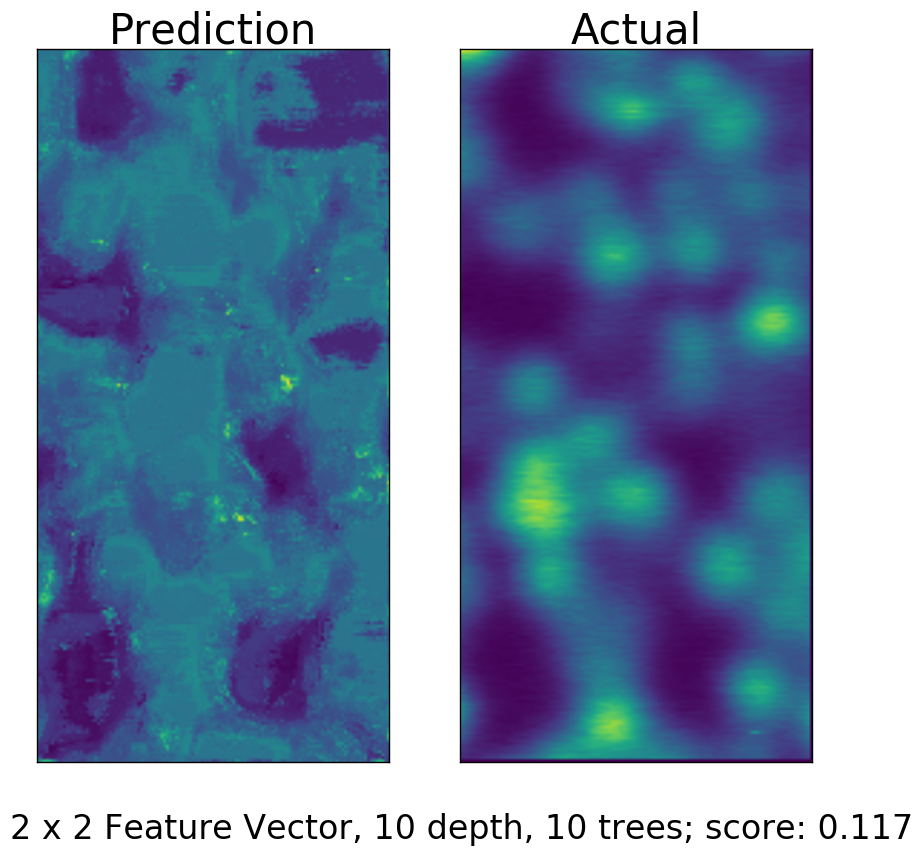

In [3]:
selfCompare(['MABr.1.Ht', 'MABr.1.Po', 'MABr.1.Ph', 'MABr.1.Am'], 'MABr.1.Pl',\
         n_feature_vector=2, n_trees=10, n_depth=10)

In [3]:
def crossCompare(x_input1, y_input1, x_input2, y_input2, n_trees=5, n_depth=5, n_feature_vector=1):
    """
    crossCompare

    crossCompare trains a random forrest on the top half of a set of input images 
    and uses the bottom half to make a prediction of the photoluminescence of the same
    material. 

    crossCompare(n_trees, n_depth, n_feature_vector, x_input, y_input)

    n_trees: default 5

    n_depth: default 5

    n_feature_vector: default 1
        can be 1, 2, or 3 surrounding pixels

    x_input: no default, tuple of file names

    y_input: no default, file name
    """
    my_model = selfCompare(x_input1, y_input1, n_trees=n_trees, n_depth=n_depth, n_feature_vector=n_feature_vector)
    ###import modules
    import numpy as np
    
    
    ###User specified parameters
    inputs=np.zeros(len(x_input2), dtype=object)
    Pl=np.loadtxt('../data/%s.txt' % y_input2,skiprows=0, dtype=np.float64)

    x9x9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    x7x7 = [-3, -2, -1, 0, 1, 2, 3]
    x5x5 = [-2, -1, 0, 1, 2]
    x3x3 = [-1, 0, 1]

    pixel_handles = [x3x3, x5x5, x7x7, x9x9]
    
    depths = n_depth
    trees = n_trees

    for h,i in enumerate(x_input2):
        inputs[h] = np.loadtxt('../data/%s.txt' % i,skiprows=0, dtype=np.float64)
        
    ###Create training and testing arrays
    x = int(inputs[0].shape[0]/2)
    x2 = inputs[0].shape[0]
    y = inputs[0].shape[1]

 
    pixelContext = pixel_handles[n_feature_vector-1]

    Xtest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext)),(len(pixelContext)*len(pixelContext)\
                                    *len(inputs))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            j=0
            for h, i in enumerate(inputs):
                for l in pixelContext:
                    for m in pixelContext:
                        Xtest[k,j]=i[(p+l),(q+m)]
                        j=j+1
            k = k + 1


    Ytest = np.zeros(((y-(max(pixelContext)*2))*(x-max(pixelContext))))
    k=0
    for p in range(x,x2-max(pixelContext)):
        for q in range(max(pixelContext),y-max(pixelContext)):
            Ytest[k]=Pl[p,q]
            k = k + 1

    prediction = []
    hold = my_model.predict(Xtest)
    score = metrics.mean_squared_error(Ytest, hold)
    roundscore = myround(score, 0.001)
    prediction.append(hold)
    k=0
    merge = (np.array(prediction).flatten())
    Pl_predict = np.zeros(((x-max(pixelContext))*1,(y-(max(pixelContext)*2))*1))
    for l in range(1):
        for i in range((x-max(pixelContext))*1):
            for j in range (y-(max(pixelContext)*2)):
                Pl_predict[i,j+(l*(y-(max(pixelContext)*2)))] = merge[k]
                k = k + 1

    fig = plt.figure(figsize=(10,10))

    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict.T, cmap='viridis')
    #pl_ax.text(-10,275,'%s x %s Feature Vector, %s depth, %s trees; score: %s' %(n_feature_vector,n_feature_vector,n_depth,\
    #    n_trees,roundscore), size=24)
    pl_ax.axes.get_xaxis().set_ticks([])
    pl_ax.axes.get_yaxis().set_ticks([])
    pl_ax.set_title('Prediction', size=30)

    pl_ax2 = fig.add_subplot(122)
    pl_ax2.set_title('Actual', size=30)
    pl_ax2.imshow(Pl[Pl.shape[0]/2:,:].T, cmap='viridis')
    pl_ax2.axes.get_xaxis().set_ticks([])
    pl_ax2.axes.get_yaxis().set_ticks([])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,\
                        wspace=None, hspace=None)
    
    plt.show()

In [ ]:
crossCompare(x_input1, y_input1, x_input2, y_input2)

In [4]:
from tkinter import *
from tkinter import ttk
    
def calculate(**kwargs):
    """
    Calculate

    Calculate defines the calculate button on the GUI so that it runs the selfCompare function with the inputted parameters.

    Calculate(**kwargs)

    Takes any arguments. Mainly it takes the x_inputs, y_input, n_trees, n_depth, and n_feature_vector to input into 
    the selfCompare function. 
    """
    
    x_train=[xvector1.get(),xvector2.get(),xvector3.get(),xvector4.get()]
    
    if yvector.get() == '':
        print('Need to input y data!')
    
    x_in=[]
    for entry in x:
        if entry == '' :
            pass
        else:
            x_in.append(entry)
    
    selfCompare(x_input=x_in, y_input=yvector.get(), n_trees=trees.get(), n_depth=depths.get(),\
                n_feature_vector=feature_vector.get())

    root.destroy()   #closes window after execution

root = Tk()
root.title("AFM Random Forest Tree Regressor")

mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)

trees = IntVar()
depths = IntVar()
feature_vector = IntVar()
xvector1 = StringVar()
xvector2 = StringVar()
xvector3 = StringVar()
xvector4 = StringVar()
xvector5 = StringVar()
xvector6 = StringVar()
xvector7 = StringVar()
xvector8 = StringVar()

yvector = StringVar()

xinput1 = ttk.Entry(root, textvariable=xvector1).grid(column=2,row=4)
xinput2 = ttk.Entry(root, textvariable=xvector2).grid(column=2,row=5)
xinput3 = ttk.Entry(root, textvariable=xvector3).grid(column=2,row=6)
xinput4 = ttk.Entry(root, textvariable=xvector4).grid(column=2,row=7)
xinput5 = ttk.Entry(root, textvariable=xvector5).grid(column=2,row=8)
xinput6 = ttk.Entry(root, textvariable=xvector6).grid(column=2,row=9)
xinput7 = ttk.Entry(root, textvariable=xvector7).grid(column=2,row=10)
ttk.Label(root, text="--------------------------").grid(column=2,row=11)

yinput = ttk.Entry(root, textvariable=yvector).grid(column=2,row=12)
ttk.Label(root, text="X inputs into regressor: ").grid(column=1,row=4)
ttk.Label(root, text="Y inputs into regressor: ").grid(column=1,row=12)
ttk.Label(root, text="Input as many X's as you want (up to 8)").grid(column=3,row=4)


trees_entry = Spinbox(root, from_=1.0, to=20.0, textvariable=trees)
depths_entry= Spinbox(root, from_=1.0, to=20.0, textvariable=depths)
features_entry= Spinbox(root, from_=1.0, to=3.0, textvariable=feature_vector)

depths_entry.grid(column=2, row=1, sticky=W)
trees_entry.grid(column=2, row=2, sticky=W)
features_entry.grid(column=3,row=2)

ttk.Button(root, text="Calculate", command=calculate).grid(column=2, row=13, sticky=W)
           
ttk.Label(root, text="Depth of Trees: ").grid(column=1, row=1, sticky=E)
ttk.Label(root, text="Number of Trees: ").grid(column=1, row=2,  sticky=E)
ttk.Label(root, text="Size of Feature Vector:").grid(column=3, row=1, sticky=(W,E))

for child in root.winfo_children(): child.grid_configure(padx=5, pady=5)

depths_entry.focus()

root.mainloop()

In [10]:
from tkinter import *
from tkinter import ttk
    
def calculate_self_compare(**kwargs):
    """
    calculate_self_compare

    calculate_self_compare defines the calculate button on the GUI so that it runs the selfCompare function with the inputted parameters.

    calculate_self_compare(**kwargs)

    Takes any arguments. Mainly it takes the x_inputs, y_input, n_trees, n_depth, and n_feature_vector to input into 
    the selfCompare function. 
    """
    
    x=[xvector1.get(),xvector2.get(),xvector3.get(),xvector4.get(),xvector5.get(),xvector6.get(),xvector7.get()]
    
    if yvector.get() == '':
        print('Need to input y data!')
    
    x_in=[]
    for entry in x:
        if entry == '' :
            pass
        else:
            x_in.append(entry)
    
    selfCompare(x_input=x_in, y_input=yvector.get(), n_trees=trees.get(), n_depth=depths.get(),\
                n_feature_vector=feature_vector.get())

    #root.destroy()   #closes window after execution

def calculate_cross_compare(**kwargs):
    """
    calculate_cross_compare

    calculate_cross_compare defines the calculate button on the GUI so that it runs the selfCompare function with the inputted parameters.

    calculate_cross_compare(**kwargs)

    Takes any arguments. Mainly it takes the x_inputs, y_input, n_trees, n_depth, and n_feature_vector to input into 
    the selfCompare function. 
    """
    
    x_train=[xvector1A.get(),xvector2A.get(),xvector3A.get(),xvector4A.get(),xvector5A.get(),xvector6A.get(),xvector7A.get()]
    x_test =[xvector1B.get(),xvector2B.get(),xvector3B.get(),xvector4B.get(),xvector5B.get(),xvector6B.get(),xvector7B.get()]

    if yvectorA.get() == '':
        print('Need to input y training data!')
    if yvectorB.get() =='':
        print('Need to input y testing data!')
    
    x_inA=[]
    for entry in x_train:
        if entry == '' :
            pass
        else:
            x_inA.append(entry)
    x_inB=[]
    for entry in x_test:
        if entry == '' :
            pass
        else:
            x_inB.append(entry)
    
    crossCompare(x_input1=x_inA, y_input1=yvectorA.get(), x_input2=x_inB, y_input2=yvectorB.get(), n_trees=trees.get(),\
                n_depth=depths.get(), n_feature_vector=feature_vector.get())
    
def self_compare_window():
    top = Toplevel(root)
    top.title("AFM Random Forest Tree Regressor Self Compare")

    mainframe = ttk.Frame(top, padding="3 3 12 12")
    mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
    mainframe.columnconfigure(0, weight=1)
    mainframe.rowconfigure(0, weight=1)

    trees = IntVar()
    depths = IntVar()
    feature_vector = IntVar()
    xvector1 = StringVar()
    xvector2 = StringVar()
    xvector3 = StringVar()
    xvector4 = StringVar()
    xvector5 = StringVar()
    xvector6 = StringVar()
    xvector7 = StringVar()

    yvector = StringVar()

    xinput1 = ttk.Entry(top, textvariable=xvector1).grid(column=2,row=4)
    xinput2 = ttk.Entry(top, textvariable=xvector2).grid(column=2,row=5)
    xinput3 = ttk.Entry(top, textvariable=xvector3).grid(column=2,row=6)
    xinput4 = ttk.Entry(top, textvariable=xvector4).grid(column=2,row=7)
    xinput5 = ttk.Entry(top, textvariable=xvector5).grid(column=2,row=8)
    xinput6 = ttk.Entry(top, textvariable=xvector6).grid(column=2,row=9)
    xinput7 = ttk.Entry(top, textvariable=xvector7).grid(column=2,row=10)
    ttk.Label(top, text="--------------------------").grid(column=2,row=11)

    yinput = ttk.Entry(top, textvariable=yvector).grid(column=2,row=12)
    ttk.Label(top, text="X inputs into regressor: ").grid(column=1,row=4)
    ttk.Label(top, text="Y inputs into regressor: ").grid(column=1,row=12)
    ttk.Label(top, text="Input as many X's as you want (up to 8)").grid(column=3,row=4)


    trees_entry = Spinbox(top, from_=1.0, to=20.0, textvariable=trees)
    depths_entry= Spinbox(top, from_=1.0, to=20.0, textvariable=depths)
    features_entry= Spinbox(top, from_=1.0, to=3.0, textvariable=feature_vector)

    depths_entry.grid(column=2, row=1, sticky=W)
    trees_entry.grid(column=2, row=2, sticky=W)
    features_entry.grid(column=3,row=2)

    ttk.Button(top, text="Calculate", command=calculate_self_compare).grid(column=2, row=13, sticky=W)
           
    ttk.Label(top, text="Depth of Trees: ").grid(column=1, row=1, sticky=E)
    ttk.Label(top, text="Number of Trees: ").grid(column=1, row=2,  sticky=E)
    ttk.Label(top, text="Size of Feature Vector:").grid(column=3, row=1, sticky=(W,E))

    for child in top.winfo_children(): child.grid_configure(padx=5, pady=5)

    depths_entry.focus()

def cross_compare_window():
    top2 = Toplevel(root)
    top2.title("AFM Random Forest Tree Regressor Cross Compare")

    mainframe = ttk.Frame(top2, padding="3 3 12 12")
    mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
    mainframe.columnconfigure(0, weight=1)
    mainframe.rowconfigure(0, weight=1)

    trees = IntVar()
    depths = IntVar()
    feature_vector = IntVar()
    xvector1A = StringVar()
    xvector2A = StringVar()
    xvector3A = StringVar()
    xvector4A = StringVar()
    xvector5A = StringVar()
    xvector6A = StringVar()
    xvector7A = StringVar()
    
    xvector1B = StringVar()
    xvector2B = StringVar()
    xvector3B = StringVar()
    xvector4B = StringVar()
    xvector5B = StringVar()
    xvector6B = StringVar()
    xvector7B = StringVar()

    yvectorA = StringVar()
    yvectorB = StringVar()
    ttk.Label(top2, text="--------------------------------------------------------------------------------------------------------------------------------------").grid(column=1,row=2,columnspan=7)

    xinput1A = ttk.Entry(top2, textvariable=xvector1A).grid(column=2,row=4)
    xinput2A = ttk.Entry(top2, textvariable=xvector2A).grid(column=2,row=5)
    xinput3A = ttk.Entry(top2, textvariable=xvector3A).grid(column=2,row=6)
    xinput4A = ttk.Entry(top2, textvariable=xvector4A).grid(column=2,row=7)
    xinput5A = ttk.Entry(top2, textvariable=xvector5A).grid(column=2,row=8)
    xinput6A = ttk.Entry(top2, textvariable=xvector6A).grid(column=2,row=9)
    xinput7A = ttk.Entry(top2, textvariable=xvector7A).grid(column=2,row=10)
    ttk.Label(top2, text="--------------------------").grid(column=2,row=11)

    yinputA = ttk.Entry(top2, textvariable=yvectorA).grid(column=2,row=12)
    ttk.Label(top2, text="X inputs into regressor: ").grid(column=1,row=4)
    ttk.Label(top2, text="Y inputs into regressor: ").grid(column=1,row=12)
    ttk.Label(top2, text="Input up to 7 X's").grid(column=3,row=4)
    
    
    xinput1A = ttk.Entry(top2, textvariable=xvector1B).grid(column=6,row=4)
    xinput2A = ttk.Entry(top2, textvariable=xvector2B).grid(column=6,row=5)
    xinput3A = ttk.Entry(top2, textvariable=xvector3B).grid(column=6,row=6)
    xinput4A = ttk.Entry(top2, textvariable=xvector4B).grid(column=6,row=7)
    xinput5A = ttk.Entry(top2, textvariable=xvector5B).grid(column=6,row=8)
    xinput6A = ttk.Entry(top2, textvariable=xvector6B).grid(column=6,row=9)
    xinput7A = ttk.Entry(top2, textvariable=xvector7B).grid(column=6,row=10)
    ttk.Label(top2, text="--------------------------").grid(column=6,row=11)

    yinputB = ttk.Entry(top2, textvariable=yvectorB).grid(column=6,row=12)
    ttk.Label(top2, text="X inputs into regressor: ").grid(column=5,row=4)
    ttk.Label(top2, text="Y inputs into regressor: ").grid(column=5,row=12)
    ttk.Label(top2, text="Input up to 7 X's").grid(column=7,row=4)
    trees_entry = Spinbox(top2, from_=1.0, to=20.0, textvariable=trees)
    depths_entry= Spinbox(top2, from_=1.0, to=20.0, textvariable=depths)
    features_entry= Spinbox(top2, from_=1.0, to=3.0, textvariable=feature_vector)

    depths_entry.grid(column=2, row=1, sticky=W)
    trees_entry.grid(column=4, row=1, sticky=W)
    features_entry.grid(column=6,row=1)

    ttk.Button(top2, text="CALCULATE", command=calculate_cross_compare).grid(column=4, row=14, sticky=W)
    ttk.Button(top2, text="Quit", command=root.quit).grid(column=7,row=14)
    ttk.Label(top2, text="Depth of Trees: ").grid(column=1, row=1, sticky=E)
    ttk.Label(top2, text="Number of Trees: ").grid(column=3, row=1,  sticky=E)
    ttk.Label(top2, text="Size of Feature Vector:").grid(column=5, row=1, sticky=(W,E))
    ttk.Label(top2, text=":Training Image Inputs:").grid(column=2,row=3)
    ttk.Label(top2, text=":Testing Image Inputs:").grid(column=6,row=3)

    
    
    for child in top2.winfo_children(): child.grid_configure(padx=5, pady=5)

    depths_entry.focus()

root = Tk()
ttk.Button(root, text="Self Compare", command=self_compare_window).grid(column=1, row=1, sticky=W)
ttk.Button(root, text="Cross Compare", command=cross_compare_window).grid(column=2,row=1,sticky=W)
#root.destroy()
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Garrett\Miniconda3\lib\tkinter\__init__.py", line 1550, in __call__
    return self.func(*args)
  File "<ipython-input-10-f5f938d06e0f>", line 16, in calculate_self_compare
    x=[xvector1.get(),xvector2.get(),xvector3.get(),xvector4.get(),xvector5.get(),xvector6.get(),xvector7.get()]
NameError: name 'xvector1' is not defined


C:\Users\Garrett\Miniconda3\lib\site-packages\ipykernel\__main__.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


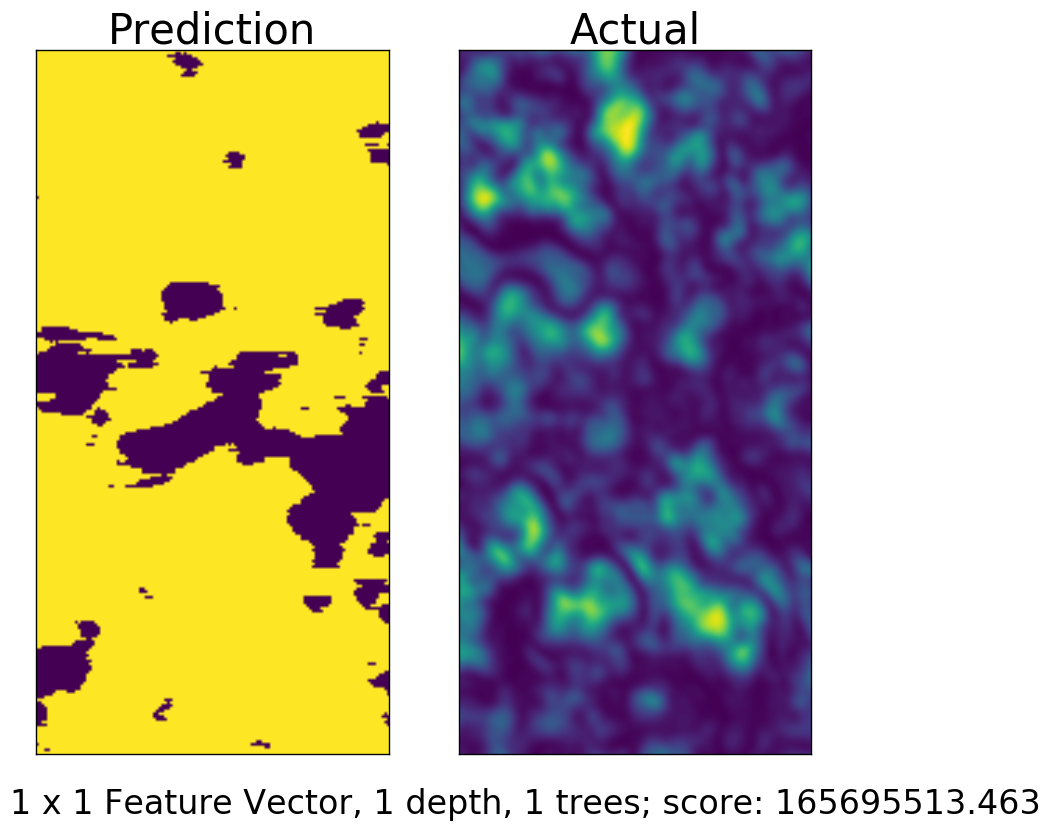

In [5]:
from tkinter import *
from tkinter import ttk

def calculate(**kwargs):
    """
    calculate

    calculate defines the calculate button on the GUI so that it runs either the selfCompare or crossCompare function with the 
    inputted parameters.
    
    First, it tests to see if all the entries in the right panel if empty. If they are, it will run the selfCompare function 
    later. If not, it will run the crossCompare function. It also makes sure there is at least one yvector inputted. Finally, 
    it sets up all the inputs for entry into the functions, ignoring all the empty entries.

    calculate(**kwargs)

    Takes any arguments. Mainly it takes all the x_inputs, y_inputs, n_trees, n_depth, and n_feature_vector to input into 
    the functions. 
    """
    
    x_train=[xvector1A.get(),xvector2A.get(),xvector3A.get(),xvector4A.get(),xvector5A.get(),xvector6A.get(),xvector7A.get()]
    x_test =[xvector1B.get(),xvector2B.get(),xvector3B.get(),xvector4B.get(),xvector5B.get(),xvector6B.get(),xvector7B.get()]
    
    sum_B=0
    for x in x_test:
        if x != '':
            sum_B+=1
        else:
            pass
    
    if yvectorA.get() == '':
        print('Need to input y training data!')
    
    x_inA=[]
    for entry in x_train:
        if entry == '' :
            pass
        else:
            x_inA.append(entry)
        
    if sum_B == 0:
        selfCompare(x_input=x_inA, y_input=yvectorA.get(), n_trees=trees.get(), n_depth=depths.get(),\
                n_feature_vector=feature_vector.get())
    else:
        x_inB=[]
        for entry in x_test:
            if entry == '' :
                pass
            else:
                x_inB.append(entry)
        crossCompare(x_input1=x_inA, y_input1=yvectorA.get(), x_input2=x_inB, y_input2=yvectorB.get(), n_trees=trees.get(),\
                n_depth=depths.get(), n_feature_vector=feature_vector.get())
        

root = Tk()
root.title("AFM Random Forest Tree Regressor")

mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)

trees = IntVar()
depths = IntVar()
feature_vector = IntVar()
xvector1A = StringVar()
xvector2A = StringVar()
xvector3A = StringVar()
xvector4A = StringVar()
xvector5A = StringVar()
xvector6A = StringVar()
xvector7A = StringVar()
   
xvector1B = StringVar()
xvector2B = StringVar()
xvector3B = StringVar()
xvector4B = StringVar()
xvector5B = StringVar()
xvector6B = StringVar()
xvector7B = StringVar()

yvectorA = StringVar()
yvectorB = StringVar()
ttk.Label(root, text="--------------------------------------------------------------------------------------------------------------------------------------").grid(column=1,row=2,columnspan=7)

xinput1A = ttk.Entry(root, textvariable=xvector1A).grid(column=2,row=5)
xinput2A = ttk.Entry(root, textvariable=xvector2A).grid(column=2,row=6)
xinput3A = ttk.Entry(root, textvariable=xvector3A).grid(column=2,row=7)
xinput4A = ttk.Entry(root, textvariable=xvector4A).grid(column=2,row=8)
xinput5A = ttk.Entry(root, textvariable=xvector5A).grid(column=2,row=9)
xinput6A = ttk.Entry(root, textvariable=xvector6A).grid(column=2,row=10)
xinput7A = ttk.Entry(root, textvariable=xvector7A).grid(column=2,row=11)
ttk.Label(root, text="--------------------------").grid(column=2,row=12)

yinputA = ttk.Entry(root, textvariable=yvectorA).grid(column=2,row=13)
ttk.Label(root, text="X inputs into regressor: ").grid(column=1,row=5)
ttk.Label(root, text="Y inputs into regressor: ").grid(column=1,row=13)
ttk.Label(root, text="Input up to 7 X's").grid(column=3,row=5)
    
xinput1B = ttk.Entry(root, textvariable=xvector1B).grid(column=6,row=5)
xinput2B = ttk.Entry(root, textvariable=xvector2B).grid(column=6,row=6)
xinput3B = ttk.Entry(root, textvariable=xvector3B).grid(column=6,row=7)
xinput4B = ttk.Entry(root, textvariable=xvector4B).grid(column=6,row=8)
xinput5B = ttk.Entry(root, textvariable=xvector5B).grid(column=6,row=9)
xinput6B = ttk.Entry(root, textvariable=xvector6B).grid(column=6,row=10)
xinput7B = ttk.Entry(root, textvariable=xvector7B).grid(column=6,row=11)
ttk.Label(root, text="--------------------------").grid(column=6,row=12)

yinputB = ttk.Entry(root, textvariable=yvectorB).grid(column=6,row=13)
ttk.Label(root, text="X inputs into regressor: ").grid(column=5,row=5)
ttk.Label(root, text="Y inputs into regressor: ").grid(column=5,row=13)
ttk.Label(root, text="Input up to 7 X's").grid(column=7,row=5)

trees_entry = Spinbox(root, from_=1.0, to=20.0, textvariable=trees).grid(column=2, row=1, sticky=W)
depths_entry= Spinbox(root, from_=1.0, to=20.0, textvariable=depths).grid(column=4, row=1, sticky=W)
features_entry= Spinbox(root, from_=1.0, to=3.0, textvariable=feature_vector).grid(column=6,row=1)

ttk.Button(root, text="CALCULATE", command=calculate).grid(column=4, row=15, sticky=W)
ttk.Button(root, text="Quit", command=root.destroy).grid(column=7,row=15)

ttk.Label(root, text="Depth of Trees: ").grid(column=1, row=1, sticky=E)
ttk.Label(root, text="Number of Trees: ").grid(column=3, row=1,  sticky=E)
ttk.Label(root, text="Size of Feature Vector:").grid(column=5, row=1, sticky=(W,E))
ttk.Label(root, text=":Training Image Inputs:").grid(column=2,row=4)
ttk.Label(root, text=":Testing Image Inputs:").grid(column=6,row=4)
ttk.Label(root, text="ONLY USE PANELS ON LEFT IF USING SELFCOMPARE").grid(column=1,row=3,columnspan=7) 
    
for child in root.winfo_children(): child.grid_configure(padx=5, pady=5)

root.mainloop()